In [19]:
import glob
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
from utility.cvat_annot_processing import CVATAnnot, cleanup_no_label_img

annot_basedirs = [
    "/Users/javkhlan-ochirganbat/Downloads/shrimp_A2_no_light/obj_train_data/"
]

cvat_annot_obj = {}
outdir = "/Users/javkhlan-ochirganbat/temp/shrimp_dataset_v3/"

for basedir in annot_basedirs:
    cleanup_no_label_img(basedir=basedir)
    vid_name = basedir.rstrip("/").split("/")[-2]
    cvat_obj = CVATAnnot(video_name=vid_name, annot_dir=basedir, max_image_count=500)
    cvat_annot_obj[vid_name] = cvat_obj
    cvat_obj.output_fltrd_data(outdir)

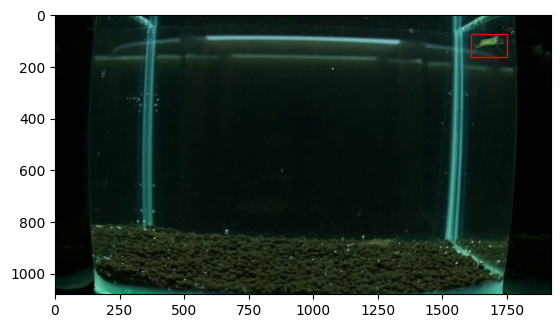

In [78]:
from utility.image_processing import show_img_with_bounding_box

img_file = "/Users/javkhlan-ochirganbat/temp/shrimp_dataset_v3/train/images/shrimp/shrimp_A2_no_light_003852.PNG"
label_file = "/Users/javkhlan-ochirganbat/temp/shrimp_dataset_v3/train/labels/shrimp/shrimp_A2_no_light_003852.txt"

show_img_with_bounding_box(img_file, label_file)

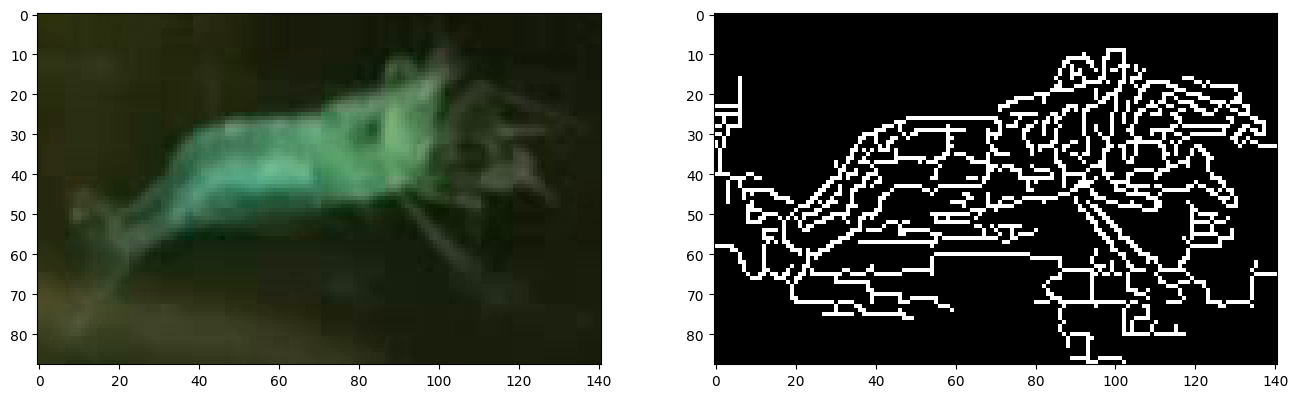

In [79]:
bbox_df = pd.read_csv(
    label_file,
    header=None,
    sep=" ",
)
orig_img = cv.imread(img_file)
height, width, _ = orig_img.shape

nrows = bbox_df.shape[0]
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 8))
for idx, row in bbox_df.iterrows():
    _, xcenter, ycenter, patch_width, patch_height = row.values
    xcenter, ycenter, patch_width, patch_height = (
        xcenter * width,
        ycenter * height,
        patch_width * width,
        patch_height * height,
    )
    x1, x2 = int(xcenter - patch_width / 2), int(xcenter + patch_width / 2)
    y1, y2 = int(ycenter - patch_height / 2), int(ycenter + patch_height / 2)
    shrimp_focused = orig_img[y1:y2, x1:x2]
    edges = cv.Canny(shrimp_focused[:, :, 0], 0, 100)
    if nrows == 1:
        ax[0].imshow(shrimp_focused)
        ax[1].imshow(edges, cmap="gray")        
    else:
        ax[idx][0].imshow(shrimp_focused)
        ax[idx][1].imshow(edges, cmap="gray")

plt.show()

In [44]:
orig_img.shape

(1080, 1920, 3)

In [64]:
from ultralytics import YOLO

model_path = "/Users/javkhlan-ochirganbat/temp/runs2/detect/train2/weights/last.pt"
input_video = "/Users/javkhlan-ochirganbat/temp/tet_visit_videos/Big_Fat_Prawn/Training_Videos/TET_visit_videos/2/2a.mov"
confidence_threshold = 0.5

model = YOLO(model=model_path)
tracking_parameters = dict(
    source=input_video, conf=confidence_threshold, stream=True, verbose=False
)

tracking_parameters["save"] = True

result = model.track(**tracking_parameters)  # Default tracker is ByteTrack

In [65]:
tracked_object = []
for idx, res in enumerate(result):
    tracked_object.append(res)
    break

In [62]:
cv.imwrite("./opencv_image_analysis/backgroung.png", tracked_object[351])

True

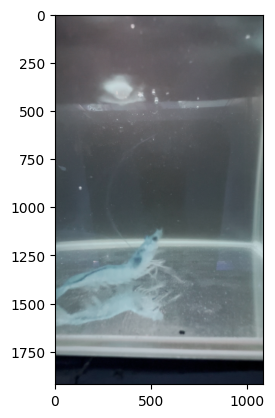

In [66]:
plt.imshow(res.orig_img)

In [70]:
bbox = tracked_object[0].boxes
xcenter, ycenter, patch_width, patch_height = bbox.xywh[0].tolist()
shrimp_focused = res.orig_img[
    int(ycenter - patch_height / 2) : int(ycenter + patch_height / 2),
    int(xcenter - patch_width / 2) : int(xcenter + patch_width / 2),
]

In [73]:
bbox.xywh[0].tolist()

[308.5859069824219, 1287.8482666015625, 592.2390747070312, 380.813232421875]

In [71]:
grey_shrimp_focused = cv.cvtColor(shrimp_focused, cv.COLOR_RGB2GRAY)

In [9]:
# plt.hist(grey_shrimp_focused.flatten())

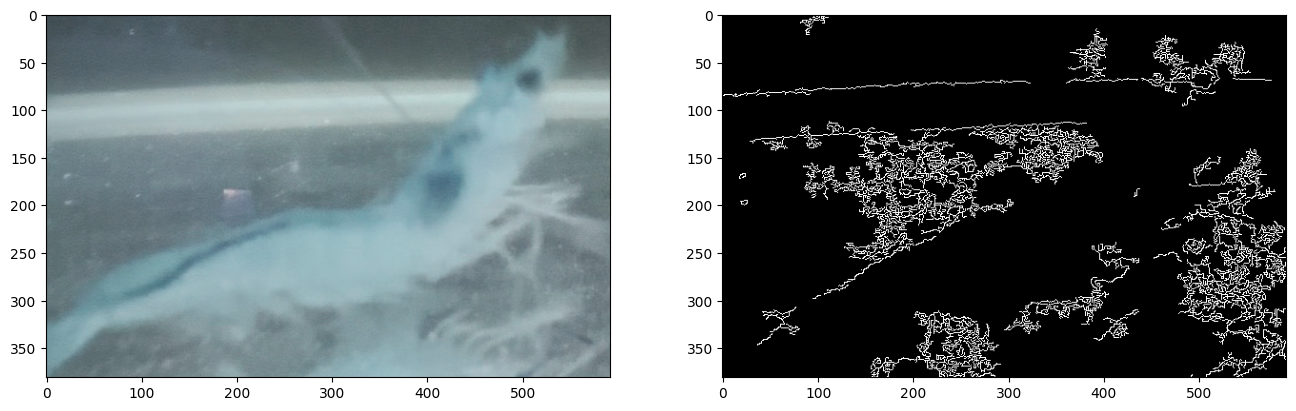

In [72]:
edges = cv.Canny(shrimp_focused[:, :, 0], 0, 100)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax[0].imshow(shrimp_focused)
ax[1].imshow(edges, cmap="gray")
plt.show()

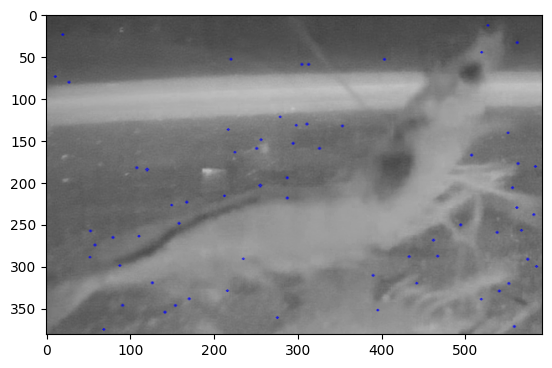

In [51]:
params = cv.SimpleBlobDetector_Params()
# Change thresholds
# params.minThreshold = 10
# params.maxThreshold = 200

# Filter by Area.
params.filterByArea = False
params.minArea = 100

# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.2

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 1

detector = cv.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(shrimp_focused)

shrimp_focused_with_keypoints = cv.drawKeypoints(
    shrimp_focused[:, :, 0],
    keypoints,
    np.array([]),
    (0, 0, 255),
    cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

plt.imshow(shrimp_focused_with_keypoints)

In [23]:
keypoints

()

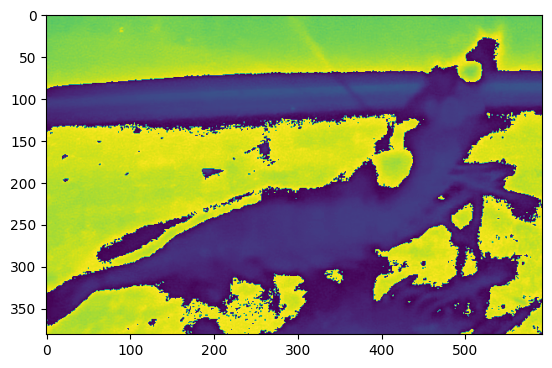

In [25]:
plt.imshow(grey_shrimp_focused - 140)

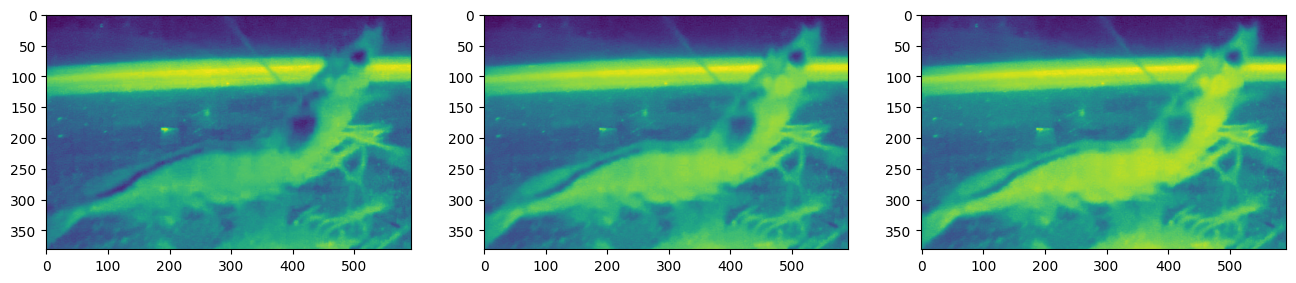

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
for i in range(3):
    ax[i].imshow(shrimp_focused[:, :, i])

plt.show()

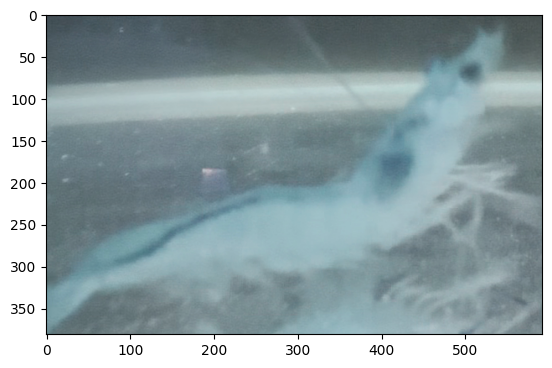

In [49]:
plt.imshow(shrimp_focused)

In [ ]:
# Detect blobs.
keypoints = detector.detect(shrimp_focused)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv.drawKeypoints(
    im, keypoints, np.array([]), (0, 0, 255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Show keypoints
cv.imshow("Keypoints", im_with_keypoints)
cv.waitKey(0)

In [8]:
from collections import defaultdict

id_to_box = defaultdict(list)
for bbox in tracked_object:
    if bbox.id is not None:
        coord_list = bbox.xywhn.tolist()
        for idx, obj_id in enumerate(bbox.id.tolist()):
            id_to_box[obj_id].append(coord_list[idx])

In [9]:
# df = pd.DataFrame.from_records(id_to_box[1])
# df.columns = ["x", "y", "w", "h"]

In [3]:
# v_delta = df.diff().fillna(0)
# v_delta["distance"] = np.sqrt(v_delta["x"] ** 2 + v_delta["y"] ** 2)
# v_delta.head()

In [11]:
# plt.bar(range(len(v_delta["distance"])), v_delta["distance"])

In [12]:
# plt.scatter(v_delta["x"], v_delta["y"])
# plt.show()

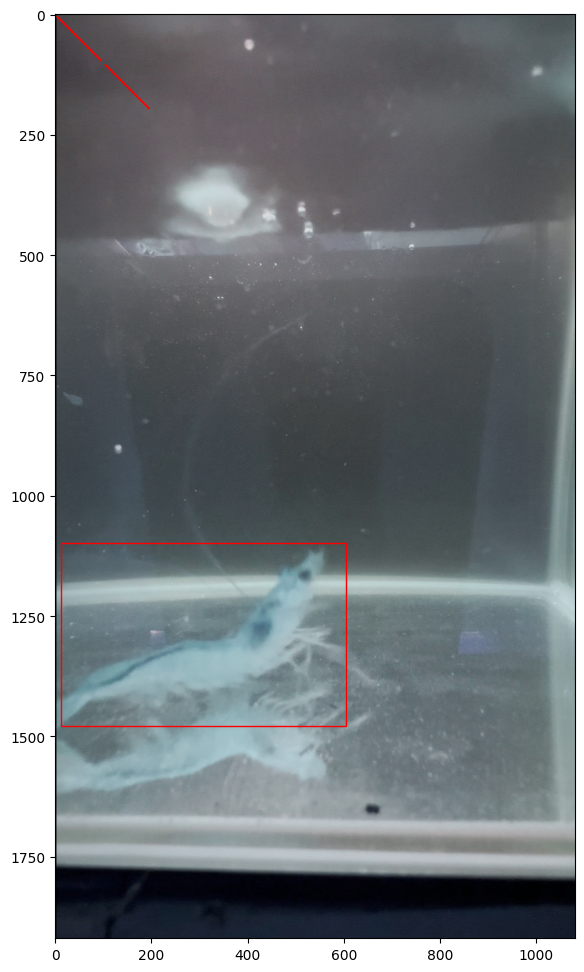

In [174]:
import matplotlib.patches as patches


def add_tracker_rect(x, y, pw, ph, history):
    patch_list = []
    patch_list.append(
        patches.Rectangle(
            (x - pw / 2, y - ph / 2),
            patch_width,
            patch_height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
    )
    px, py = history[0]
    for (cx, cy) in history[1:]:
        patch_list.append(patches.FancyArrowPatch((px, py), (cx, cy), color="red"))
        px, py = cx, cy

    return patch_list


_, ax = plt.subplots(figsize=(8, 12))
ax.imshow(res.orig_img)
for patch in add_tracker_rect(
    xmin, ymin, patch_width, patch_height, [[0, 0], [100, 100], [200, 200]]
):
    ax.add_patch(patch)

plt.show()

In [124]:
res.orig_img.shape

(1920, 1080, 3)

In [3]:
data = glob.glob("UOT100/*/")

video_input = "UOT100/ArmyDiver1/ArmyDiver1.mp4"
annotation = "UOT100/ArmyDiver1/groundtruth_rect.txt"

df = pd.read_csv(annotation, sep="\t", header=None)

labels_dict = {
    "turtle": 0,
    "human": 1,
    "fish": 2,
    "octopus": 3,
    "squid": 4,
    "whale": 5,
    "shark": 6,
    "manta": 7,
    "dive": 1,
    "dolphin": 8,
    "eel": 9,
    "shrimp": 10,
    "diving": 2,
}

In [6]:
import os
import random
import shutil


def create_annotated_images(video_folder, labels_dict, prefix, img_count=10):
    label_name = video_folder.lower()
    ground_truth = pd.read_csv(
        os.path.join(video_folder, "groundtruth_rect.txt"), sep="\t", header=None
    )
    detected_label = None
    for label, idx in labels_dict.items():
        if label in label_name:
            detected_label = str(idx)
            break

    if not detected_label:
        print(f"Label NOT FOUND for {video_folder}")
        return

    image_list = sorted(glob.glob(os.path.join(video_folder, "img/frame*")))
    if not image_list:
        print(f"IMAGES NOT FOUND for {video_folder}")
        return
    img_height, img_width = plt.imread(image_list[0]).shape[:2]
    random.shuffle(image_list)
    selected = image_list[:img_count]

    create_dataset = True
    for img in selected:
        base_name = os.path.basename(img)
        label_idx = int(base_name.removeprefix("frame").removesuffix(".jpg"))
        new_img_name = f"{prefix:08}{label_idx}"
        if label_idx >= ground_truth.shape[0]:
            continue
        x1, y1, rec_width, rec_height = [
            int(val) for val in ground_truth.loc[label_idx].tolist()
        ]
        norm_x1 = x1 / img_width
        norm_rec_width = rec_width / img_width
        norm_y1 = y1 / img_height
        norm_rec_height = rec_height / img_height
        bounding_rect = f"{norm_x1 + norm_rec_width / 2} {norm_y1 + norm_rec_height / 2} {norm_rec_width} {norm_rec_height}"

        new_img_path = f"/Users/javkhlan-ochirganbat/repos/machine-learning/ultralytics_demo/custom_dataset/UOT100Images/images/uot100/{new_img_name}.jpg"
        if create_dataset:
            shutil.copy(img, new_img_path)
            new_label_path = f"/Users/javkhlan-ochirganbat/repos/machine-learning/ultralytics_demo/custom_dataset/UOT100Images/labels/uot100/{new_img_name}.txt"
            with open(new_label_path, "w") as outfile:
                outfile.write(f"{detected_label} {bounding_rect}\n")
            # print(detected_label, new_img_path, label_idx, label_value)
    return detected_label


# create_annotated_images("UOT100/AntiguaTurtle", labels_dict=labels_dict, prefix=1)

In [3]:
# Set to True to generate annotated image

if False:
    for idx, folder in enumerate(sorted(glob.glob("UOT100/*"))):
        create_annotated_images(
            folder, labels_dict=labels_dict, prefix=idx, img_count=200
        )